In [11]:
from model import ResNet
import tensorflow as tf
import utils
%matplotlib inline

In [2]:
eager_mode = True
if eager_mode:
    tf.enable_eager_execution()
device, data_format = utils.device_and_data_format()
x_train, y_train, x_val, y_val, x_test, y_test, x_test_raw = utils.get_CIFAR10_data(data_format)

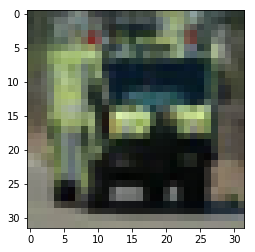

Truth: truck


In [3]:
utils.show_random_image(x_test_raw, y_test)

In [13]:
model = ResNet(data_format)

In [17]:
model.outputs